In [1]:
%matplotlib inline
import numpy as np
from sklearn import metrics
import scipy
import matplotlib.pyplot as plt
import os
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
# 500 max word length, LSTM only architecture, 20 of the top level classes, 100 epochs
# predictionPath = 'results/epochPreds_500ML_LSTM_20Class.npy'
# avgLossPath = 'results/epochAvgLoss_500ML_LSTM_20Class.npy'
# lossSavepath = 'src/plotting/resultPlotting/trainingLoss_500ML_LSTM_20Class.png'

# predictionPath = 'results/epochPreds_500ML_LSTM_20Class_paddingFix.npy'
# avgLossPath = 'results/epochAvgLoss_500ML_LSTM_20Class_paddingFix.npy'
# avgLossValidPath = 'results/epochAvgLossValid_500ML_LSTM_20Class_paddingFix.npy'
# lossSavepath = 'src/plotting/resultPlotting/trainingLoss_500ML_LSTM_20Class_paddingFix.png'
# precRecSavePath = 'src/plotting/resultPlotting/precRec_500ML_LSTM_20Class_paddingFix.png'
# rankMetricsPath = 'src/plotting/resultPlotting/rankMetricsPerf_500ML_LSTM_20Class_paddingFix.png'
# coverageErrorPath = 'src/plotting/resultPlotting/coverageError_500ML_LSTM_20Class_paddingFix.png'

# truePath = 'results/yDev.npy'

# resultPath = 'results/LSTM_300embed_500ML_50Hidden_baseline/'
# resultPath = 'results/LSTM_300embed_500ML_100Hidden/'
resultPath = 'results/rerunWithLongerNotes/'
resultPath = 'results/3LayerNNet_longRun/'
resultPath = 'results/results/run_5_27_17/'

In [3]:
epochAvgLoss = np.loadtxt(os.path.join(resultPath, 'epochAvgLoss.gz'))
epochAvgLossValid = np.loadtxt(os.path.join(resultPath, 'epochAvgLossValid.gz'))
yDev = np.loadtxt(os.path.join(resultPath, 'yDev.gz'))
yTrain = np.loadtxt(os.path.join(resultPath, 'yTrain.gz'))
epochPredictions = np.loadtxt(os.path.join(resultPath, 'epochPreds.gz'))
predsRealShape = np.loadtxt(os.path.join(resultPath, 'epochPredsShape.gz')).astype(int)
# epochPredictions = epochPredictions.reshape((epochAvgLoss.shape[0], yDev.shape[0], yDev.shape[1]))
epochPredictions = epochPredictions.reshape(predsRealShape)


In [4]:
np.loadtxt(os.path.join(resultPath, 'epochPredsShape.gz')).astype(int)

array([   13, 13181,    19])

In [5]:
print(epochPredictions.shape)
print(epochAvgLoss.shape)
print(yDev.shape)

(13, 13181, 19)
(13,)
(13181, 19)


In [6]:
with open(os.path.join(resultPath, 'hyperParamDict.pickle'), 'rb') as handle:
    hyperParamDict = pickle.load(handle)
pp.pprint(hyperParamDict)

{   'EMBED_SIZE': 300,
    'batchSize': 128,
    'inputKeepProb': 1,
    'learningRate': 0.001,
    'maxGradNorm': 5,
    'maxNoteLength': 1000,
    'n_hidden': 300,
    'numLayers': 1,
    'outputKeepProb': 0.5,
    'sizeList': [300, 150, 75, 19],
    'trainingEpochsMax': 100}


In [7]:
predsRaw = scipy.special.expit(epochPredictions)# this is sigmoid function applied element wise
preds = predsRaw
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
bestEpoch = np.argmin(epochAvgLossValid)
nEpochs = epochPredictions.shape[0]

In [8]:
epochAvgLossValid

array([ 0.48381701,  0.4741739 ,  0.46676511,  0.45534176,  0.44364616,
        0.432944  ,  0.42266154,  0.41611981,  0.41557521,  0.41823226,
        0.42355362,  0.4283236 ,  0.43178016])

In [9]:
bestEpoch = np.argmin(epochAvgLossValid)
# kinda hacky but I assume it would never be exactly zero.
print('best model at epoch %d with a validation loss of %.5f'%(bestEpoch, epochAvgLossValid[bestEpoch]))

best model at epoch 8 with a validation loss of 0.41558


In [10]:
precOverEpoch = np.zeros(preds.shape[0])
recOverEpoch = np.zeros(preds.shape[0])
f1OverEpoch = np.zeros(preds.shape[0])
coverErrOverEpoch = np.zeros(preds.shape[0])
rankLossOverEpoch = np.zeros(preds.shape[0])
lrapOverEpoch = np.zeros(preds.shape[0])
for epoch in range(preds.shape[0]):
    prec = metrics.precision_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    rec = metrics.recall_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    f1 = metrics.f1_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    coverErr = metrics.coverage_error(yDev, predsRaw[epoch, :,:])
    rankLoss = metrics.label_ranking_loss(yDev, predsRaw[epoch,:,:])
    lrap = metrics.label_ranking_average_precision_score(yDev, predsRaw[epoch,:,:])
    coverErrOverEpoch[epoch] = coverErr
    rankLossOverEpoch[epoch] = rankLoss
    lrapOverEpoch[epoch] = lrap
    precOverEpoch[epoch] = prec
    recOverEpoch[epoch] = rec
    f1OverEpoch[epoch] = f1

/home/oliver/anaconda3/envs/clinicalNoteTagger/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/oliver/anaconda3/envs/clinicalNoteTagger/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [11]:
prec = metrics.precision_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
rec = metrics.recall_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
f1 = metrics.f1_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
print('Precsion score averaged over samples %3f'%(prec))
print('Recall score averaged over samples %3f'%(rec))
print('F1 score averaged over samples %3f'%(f1))
print('Rank loss %f \n'%rankLossOverEpoch[bestEpoch])
with open(os.path.join(resultPath, 'bestPerformance.txt'), 'w') as performanceFile:
    performanceFile.write('Precsion score averaged over samples %f \n'%(prec))
    performanceFile.write('Recall score averaged over samples %f \n'%(rec))
    performanceFile.write('F1 score averaged over samples %f \n'%(f1))
    performanceFile.write('Rank loss %f \n'%rankLossOverEpoch[bestEpoch])

Precsion score averaged over samples 0.770875
Recall score averaged over samples 0.647884
F1 score averaged over samples 0.675981
Rank loss 0.435683 



/home/oliver/anaconda3/envs/clinicalNoteTagger/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/oliver/anaconda3/envs/clinicalNoteTagger/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


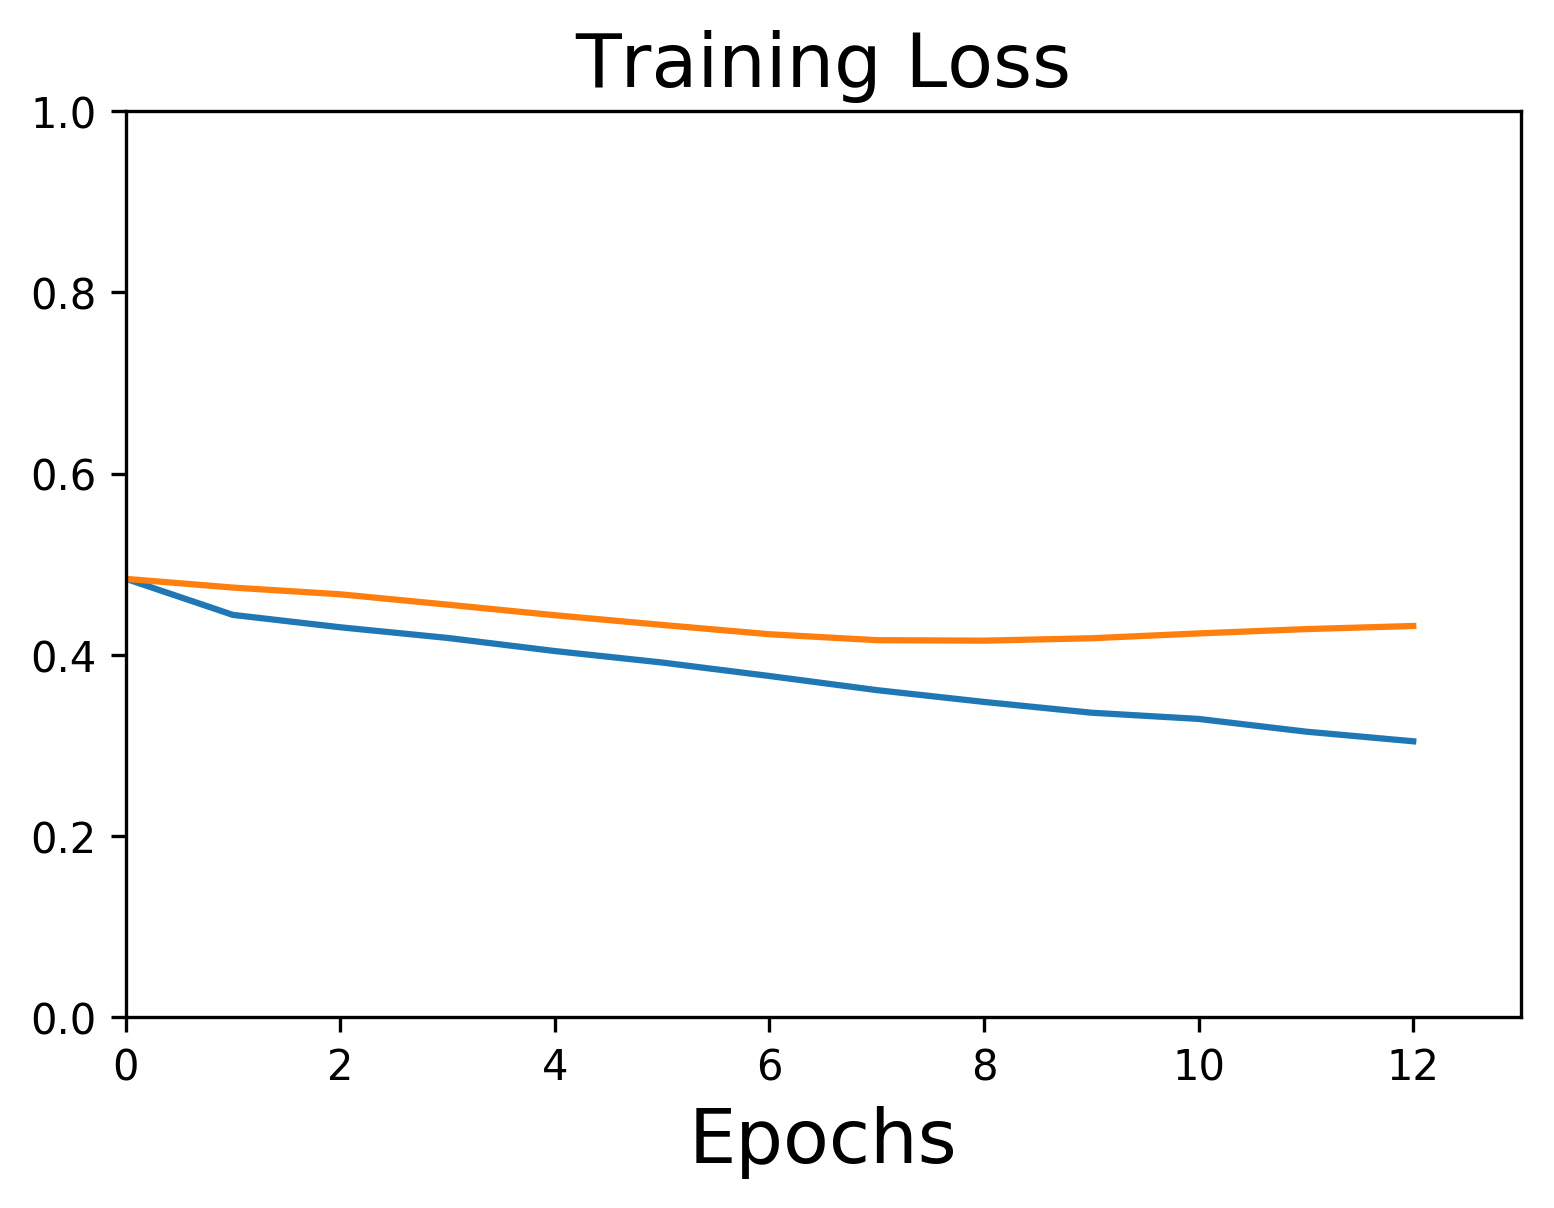

In [12]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, epochAvgLoss)
plt.plot(x, epochAvgLossValid)
plt.axis([0, epochPredictions.shape[0], 0, 1.0])
plt.title('Training Loss', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'loss.png'))

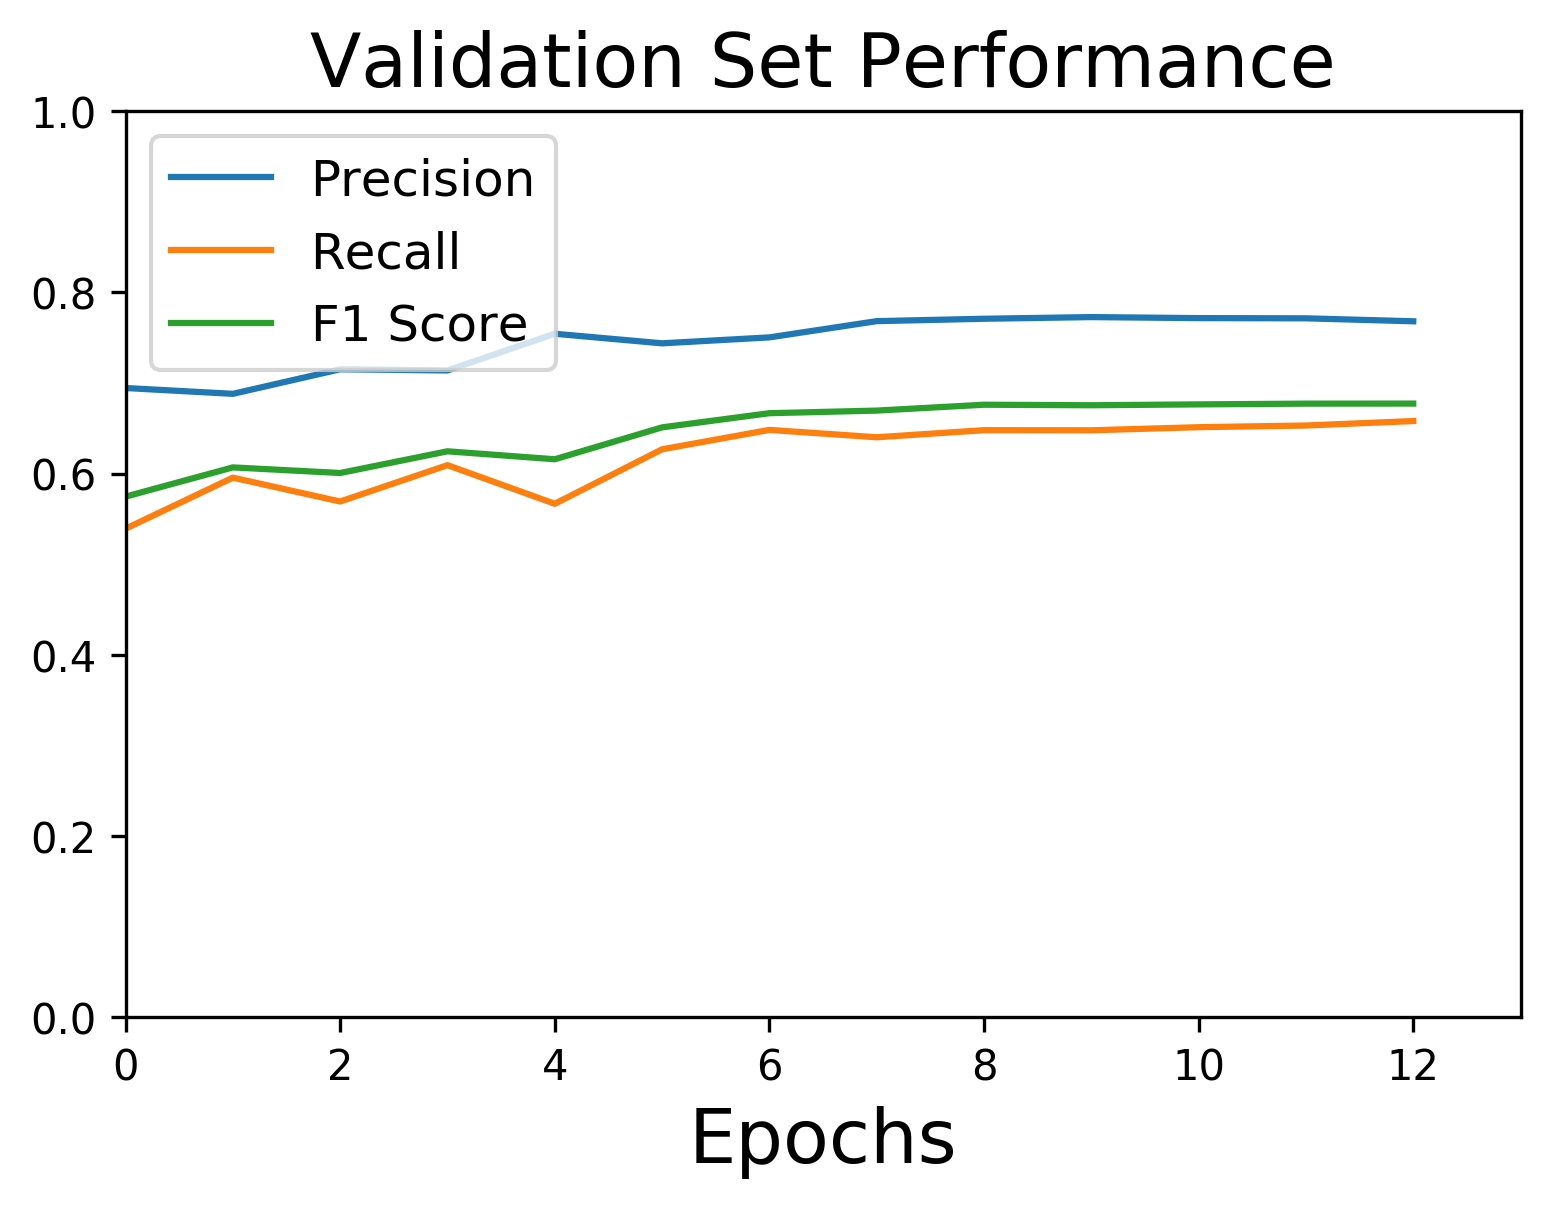

In [13]:
nEpochs = preds.shape[0]
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, precOverEpoch)
plt.plot(x, recOverEpoch)
plt.plot(x, f1OverEpoch)
plt.axis([0, nEpochs, 0, 1.0])

plt.legend(['Precision', 'Recall', 'F1 Score'], loc='upper left', fontsize = 12)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'precRecF1.png'))
# fig.savefig('src/plotting/resultPlotting/performance.png')

In [14]:
f1OverEpoch

array([ 0.57453013,  0.60681329,  0.60061805,  0.62457714,  0.61577389,
        0.6509995 ,  0.66662909,  0.66950529,  0.6759814 ,  0.67539954,
        0.67635327,  0.67717534,  0.67722712])

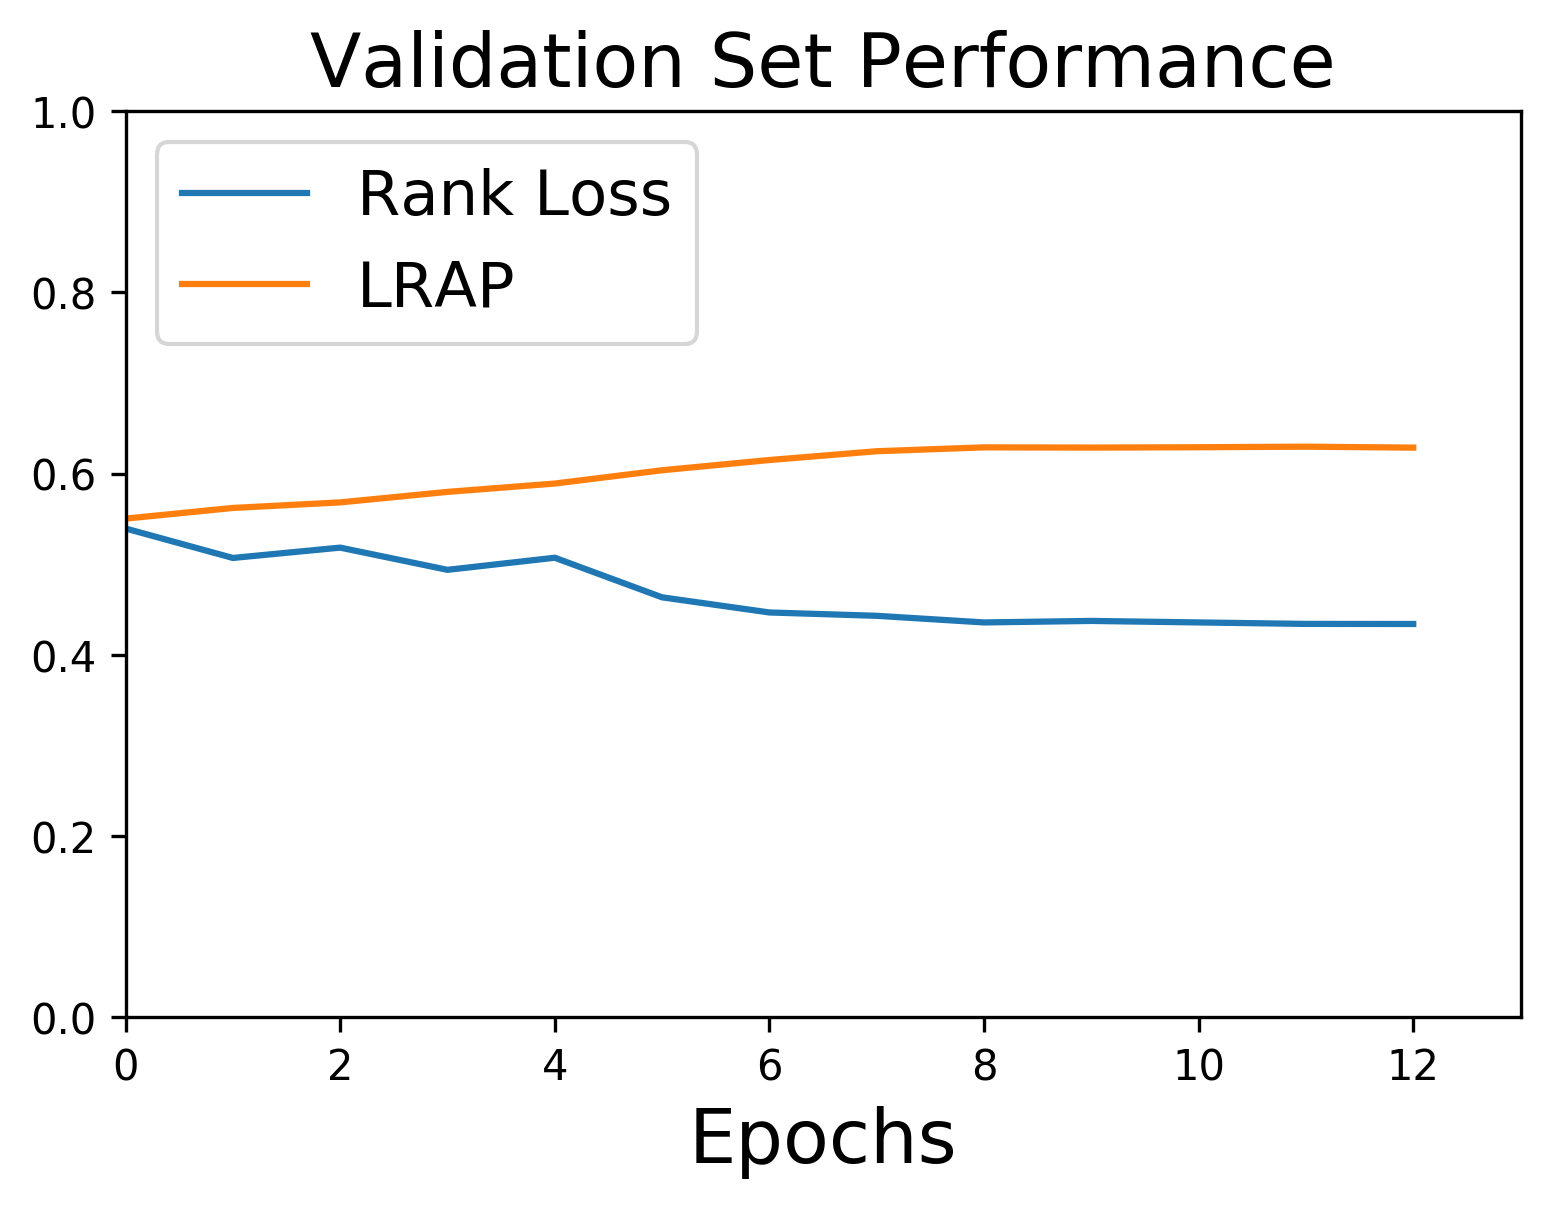

In [15]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, rankLossOverEpoch)
plt.plot(x, lrapOverEpoch)
plt.axis([0, nEpochs, 0, 1.0])

plt.legend(['Rank Loss', 'LRAP'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'rankLoss.png'))

The mean number of codes in the devSet is 6.698


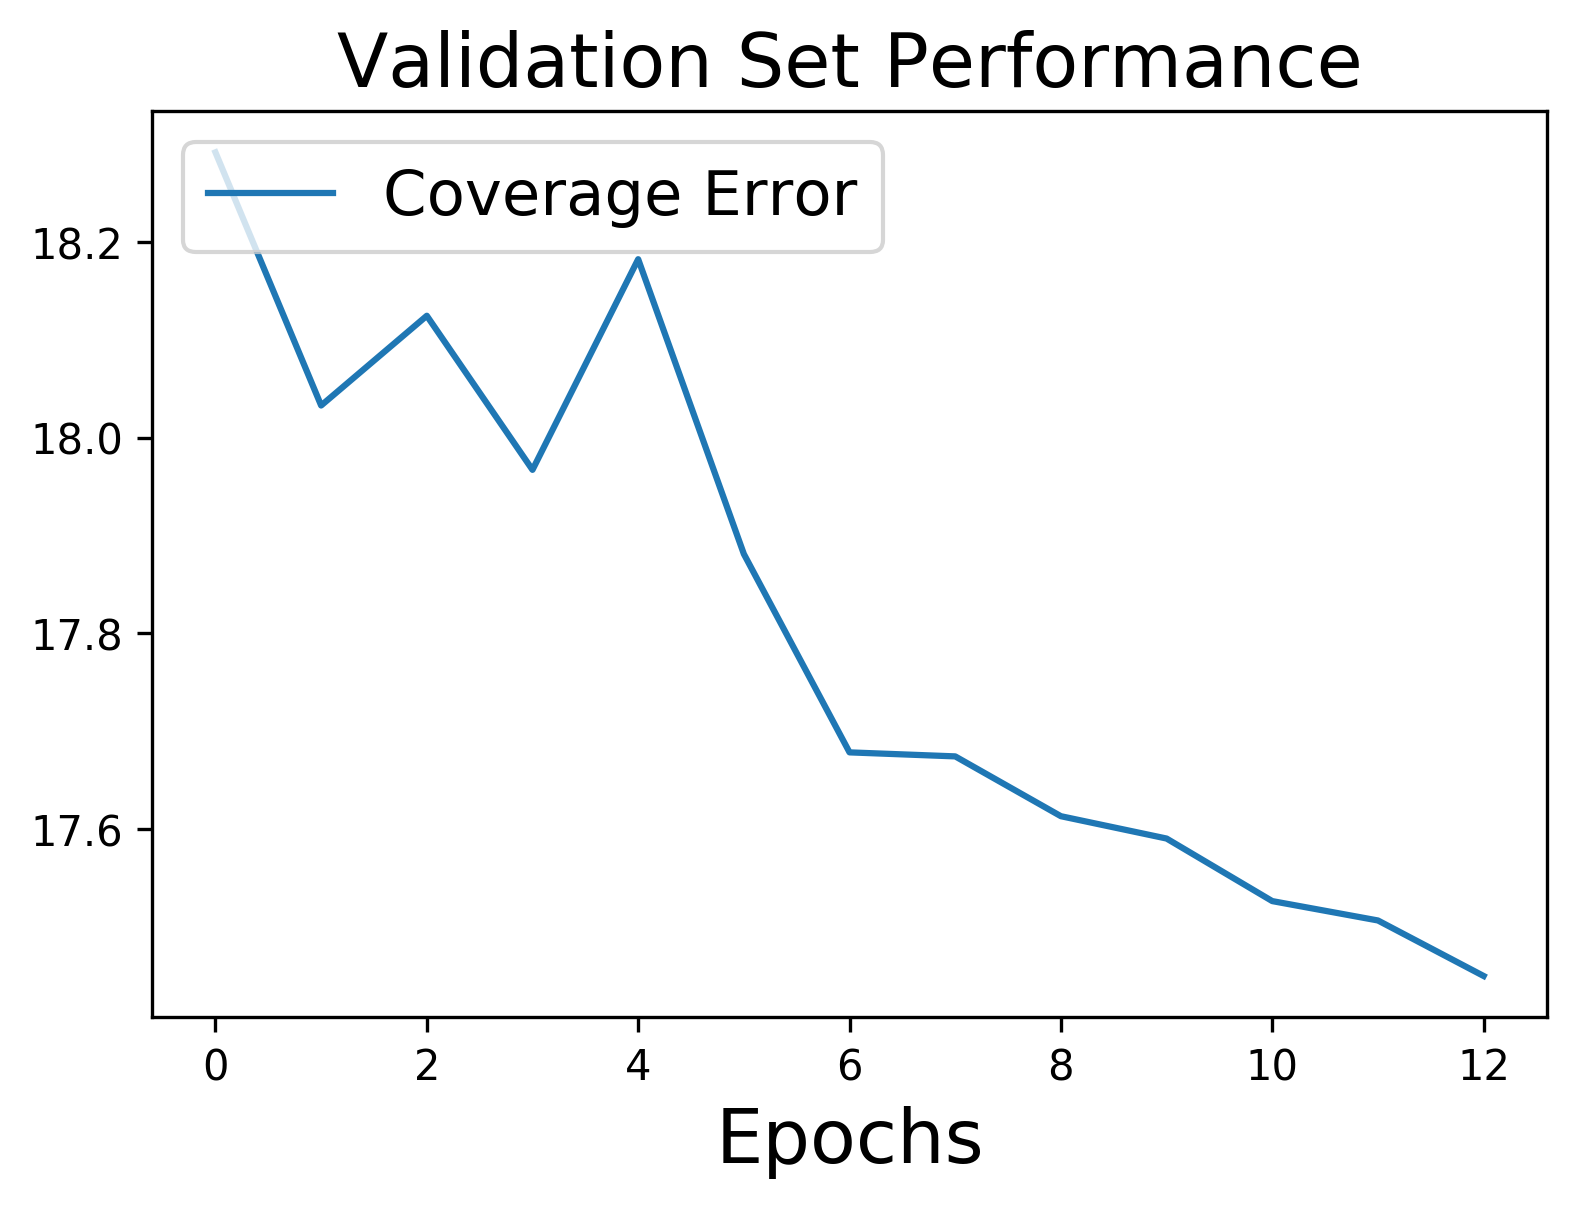

In [16]:
meanNumberOfCodes = np.sum(yDev, axis = 1)
meanNumberOfCodes = np.mean(meanNumberOfCodes)
print('The mean number of codes in the devSet is %.3f'%meanNumberOfCodes)
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, coverErrOverEpoch)

plt.legend(['Coverage Error'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'coverage.png'))

## Confusion Matrices
Thus in binary classification, the count of true negatives is $C_{0,0}$, false negatives is $C_{1,0}$, true positives is $C_{1,1}$ and false positives is $C_{0,1}$.


As of right now this code isn't real

In [74]:
with open(os.path.join(resultPath, 'features.pkl'), 'rb') as handle:
    icdDict = pickle.load(handle)[2]
#     icdDict = temp[2]
pp.pprint(icdDict)

{   'cat:1': 17,
    'cat:10': 4,
    'cat:11': 0,
    'cat:12': 10,
    'cat:13': 7,
    'cat:14': 9,
    'cat:15': 18,
    'cat:16': 1,
    'cat:17': 5,
    'cat:18': 12,
    'cat:19': 16,
    'cat:2': 13,
    'cat:3': 2,
    'cat:4': 6,
    'cat:5': 14,
    'cat:6': 3,
    'cat:7': 15,
    'cat:8': 11,
    'cat:9': 8}


In [72]:
myMapper = {'cat:1': 'ICD_001_139',
                 'cat:10': 'ICD_520_579',
                 'cat:11': 'ICD_580_629',
                 'cat:12': 'ICD_630_679',
                 'cat:13': 'ICD_680_709',
                 'cat:14': 'ICD_710_739',
                 'cat:15': 'ICD_740_759',
                 'cat:16': 'ICD_760_779',
                 'cat:17': 'ICD_780_799',
                 'cat:18': 'ICD_800_999',
                 'cat:19': 'ICD_EV',
                 'cat:2': 'ICD_140_239',
                 'cat:3': 'ICD_240_279',
                 'cat:4': 'ICD_280_289',
                 'cat:5': 'ICD_290_319',
                 'cat:6': 'ICD_320_359',
                 'cat:7': 'ICD_360_389',
                 'cat:8': 'ICD_390_459',
                 'cat:9': 'ICD_460_519'}

In [76]:
sorted(icdDict.keys())

['cat:1',
 'cat:10',
 'cat:11',
 'cat:12',
 'cat:13',
 'cat:14',
 'cat:15',
 'cat:16',
 'cat:17',
 'cat:18',
 'cat:19',
 'cat:2',
 'cat:3',
 'cat:4',
 'cat:5',
 'cat:6',
 'cat:7',
 'cat:8',
 'cat:9']

In [87]:
xAxisLabels = ['']*len(icdDict.keys())
xAxisOriginalOrder = ['']*len(icdDict.keys())
for icdKey, idx in icdDict.items():
#     print(icdKey)
#     print(idx)
    xAxisLabels[idx] = myMapper[icdKey]
    xAxisOriginalOrder[idx] = idx
print(xAxisLabels)
print(xAxisOriginalOrder)
sortedAxisLabels = np.argsort(xAxisLabels)
[xAxisLabels[sortedIdx] for sortedIdx in sortedAxisLabels]

['ICD_580_629', 'ICD_760_779', 'ICD_240_279', 'ICD_320_359', 'ICD_520_579', 'ICD_780_799', 'ICD_280_289', 'ICD_680_709', 'ICD_460_519', 'ICD_710_739', 'ICD_630_679', 'ICD_390_459', 'ICD_800_999', 'ICD_140_239', 'ICD_290_319', 'ICD_360_389', 'ICD_EV', 'ICD_001_139', 'ICD_740_759']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


['ICD_001_139',
 'ICD_140_239',
 'ICD_240_279',
 'ICD_280_289',
 'ICD_290_319',
 'ICD_320_359',
 'ICD_360_389',
 'ICD_390_459',
 'ICD_460_519',
 'ICD_520_579',
 'ICD_580_629',
 'ICD_630_679',
 'ICD_680_709',
 'ICD_710_739',
 'ICD_740_759',
 'ICD_760_779',
 'ICD_780_799',
 'ICD_800_999',
 'ICD_EV']

In [104]:
predsBest = preds[bestEpoch,:,:]
yTruth = yDev
classTrainingExamples = np.sum(yTrain, axis = 0)
# confusionMatrix = np.zeros(shape = (temp.shape[1], temp.shape[1]))
# print(confusionMatrix)-
# currTruth = np.zeros(temp.shape[1])
# currPred = np.zeros(temp.shape[1])
diseaseSpecificScores_F1 = np.zeros(classTrainingExamples.shape)
diseaseSpecificScores_Prec = np.zeros(classTrainingExamples.shape)
diseaseSpecificScores_Rec = np.zeros(classTrainingExamples.shape)
for colIdx in range(yTruth.shape[1]):
    currTruth = yTruth[:, colIdx]
    currPred = predsBest[:, colIdx]
    confMat = metrics.confusion_matrix(y_true = currTruth, y_pred = currPred)
#     print(confMat)
    prec = metrics.precision_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    rec = metrics.recall_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    f1 = metrics.f1_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    diseaseSpecificScores_F1[colIdx] = f1
    diseaseSpecificScores_Prec[colIdx] = prec
    diseaseSpecificScores_Rec[colIdx] = rec
    print('total positives {} or {} of the total'.format(np.sum(currPred), np.mean(currPred)))
    print('For Column {}'.format(colIdx))
#     print('precision {}'.format(prec))
#     print('recall {}'.format(rec))
    print('f1 score {}'.format(f1))
    print('Number of training examples {}'.format(classTrainingExamples[colIdx]))
    print('Percent of training examples {}'.format(classTrainingExamples[colIdx]/yTrain.shape[0]))
    print('***************************')
#     1/0

total positives 6395.0 or 0.48516804491313253 of the total
For Column 0
f1 score 0.7352941176470589
Number of training examples 14932.0
Percent of training examples 0.3776333426064085
***************************
total positives 53.0 or 0.004020939230710872 of the total
For Column 1
f1 score 0.9714285714285713
Number of training examples 3661.0
Percent of training examples 0.09258744088414557
***************************
total positives 11698.0 or 0.8874895683180335 of the total
For Column 2
f1 score 0.8593053491827638
Number of training examples 24762.0
Percent of training examples 0.6262360587744367
***************************
total positives 2754.0 or 0.20893710644108945 of the total
For Column 3
f1 score 0.5144168698895424
Number of training examples 9168.0
Percent of training examples 0.23186060038946915
***************************
total positives 5456.0 or 0.413929140429406 of the total
For Column 4
f1 score 0.7156583629893238
Number of training examples 14646.0
Percent of training

/home/oliver/anaconda3/envs/clinicalNoteTagger/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oliver/anaconda3/envs/clinicalNoteTagger/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


total positives 11905.0 or 0.9031939913511873 of the total
For Column 11
f1 score 0.9345294574312085
Number of training examples 30054.0
Percent of training examples 0.7600718241824941
***************************
total positives 4171.0 or 0.3164403307791518 of the total
For Column 12
f1 score 0.5896116994452849
Number of training examples 16121.0
Percent of training examples 0.4077033964745454
***************************
total positives 1791.0 or 0.13587739928685227 of the total
For Column 13
f1 score 0.6626476971304557
Number of training examples 6223.0
Percent of training examples 0.15738094635947497
***************************
total positives 2183.0 or 0.16561717623852515 of the total
For Column 14
f1 score 0.41703971119133576
Number of training examples 10989.0
Percent of training examples 0.2779140638830581
***************************
total positives 0.0 or 0.0 of the total
For Column 15
f1 score 0.0
Number of training examples 2688.0
Percent of training examples 0.067980071318378

In [95]:
# classTrainingExamples = np.sum(yTrain, axis = 0)
# confusionMatrix = np.zeros(shape = (temp.shape[1], temp.shape[1]))
# print(confusionMatrix)-
# currTruth = np.zeros(temp.shape[1])
# currPred = np.zeros(temp.shape[1])
# diseaseSpecificScores_F1 = np.zeros(classTrainingExamples.shape)
# diseaseSpecificScores_Prec = np.zeros(classTrainingExamples.shape)
# diseaseSpecificScores_Rec = np.zeros(classTrainingExamples.shape)

In [96]:
xAxisLabels = ['']*len(icdDict.keys())
xAxisOriginalOrder = ['']*len(icdDict.keys())
for icdKey, idx in icdDict.items():
#     print(icdKey)
#     print(idx)
    xAxisLabels[idx] = myMapper[icdKey]
    xAxisOriginalOrder[idx] = idx
print(xAxisLabels)
print(xAxisOriginalOrder)
sortedAxisLabels = np.argsort(xAxisLabels)
[xAxisLabels[sortedIdx] for sortedIdx in sortedAxisLabels]

['ICD_580_629', 'ICD_760_779', 'ICD_240_279', 'ICD_320_359', 'ICD_520_579', 'ICD_780_799', 'ICD_280_289', 'ICD_680_709', 'ICD_460_519', 'ICD_710_739', 'ICD_630_679', 'ICD_390_459', 'ICD_800_999', 'ICD_140_239', 'ICD_290_319', 'ICD_360_389', 'ICD_EV', 'ICD_001_139', 'ICD_740_759']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


['ICD_001_139',
 'ICD_140_239',
 'ICD_240_279',
 'ICD_280_289',
 'ICD_290_319',
 'ICD_320_359',
 'ICD_360_389',
 'ICD_390_459',
 'ICD_460_519',
 'ICD_520_579',
 'ICD_580_629',
 'ICD_630_679',
 'ICD_680_709',
 'ICD_710_739',
 'ICD_740_759',
 'ICD_760_779',
 'ICD_780_799',
 'ICD_800_999',
 'ICD_EV']

In [155]:
classTrainingExamples

array([ 14932.,   3661.,  24762.,   9168.,  14646.,  13739.,  13481.,
         4241.,  17667.,   6739.,    133.,  30054.,  16121.,   6223.,
        10989.,   2688.,  27072.,  10074.,   2334.])

/home/oliver/anaconda3/envs/clinicalNoteTagger/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oliver/anaconda3/envs/clinicalNoteTagger/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


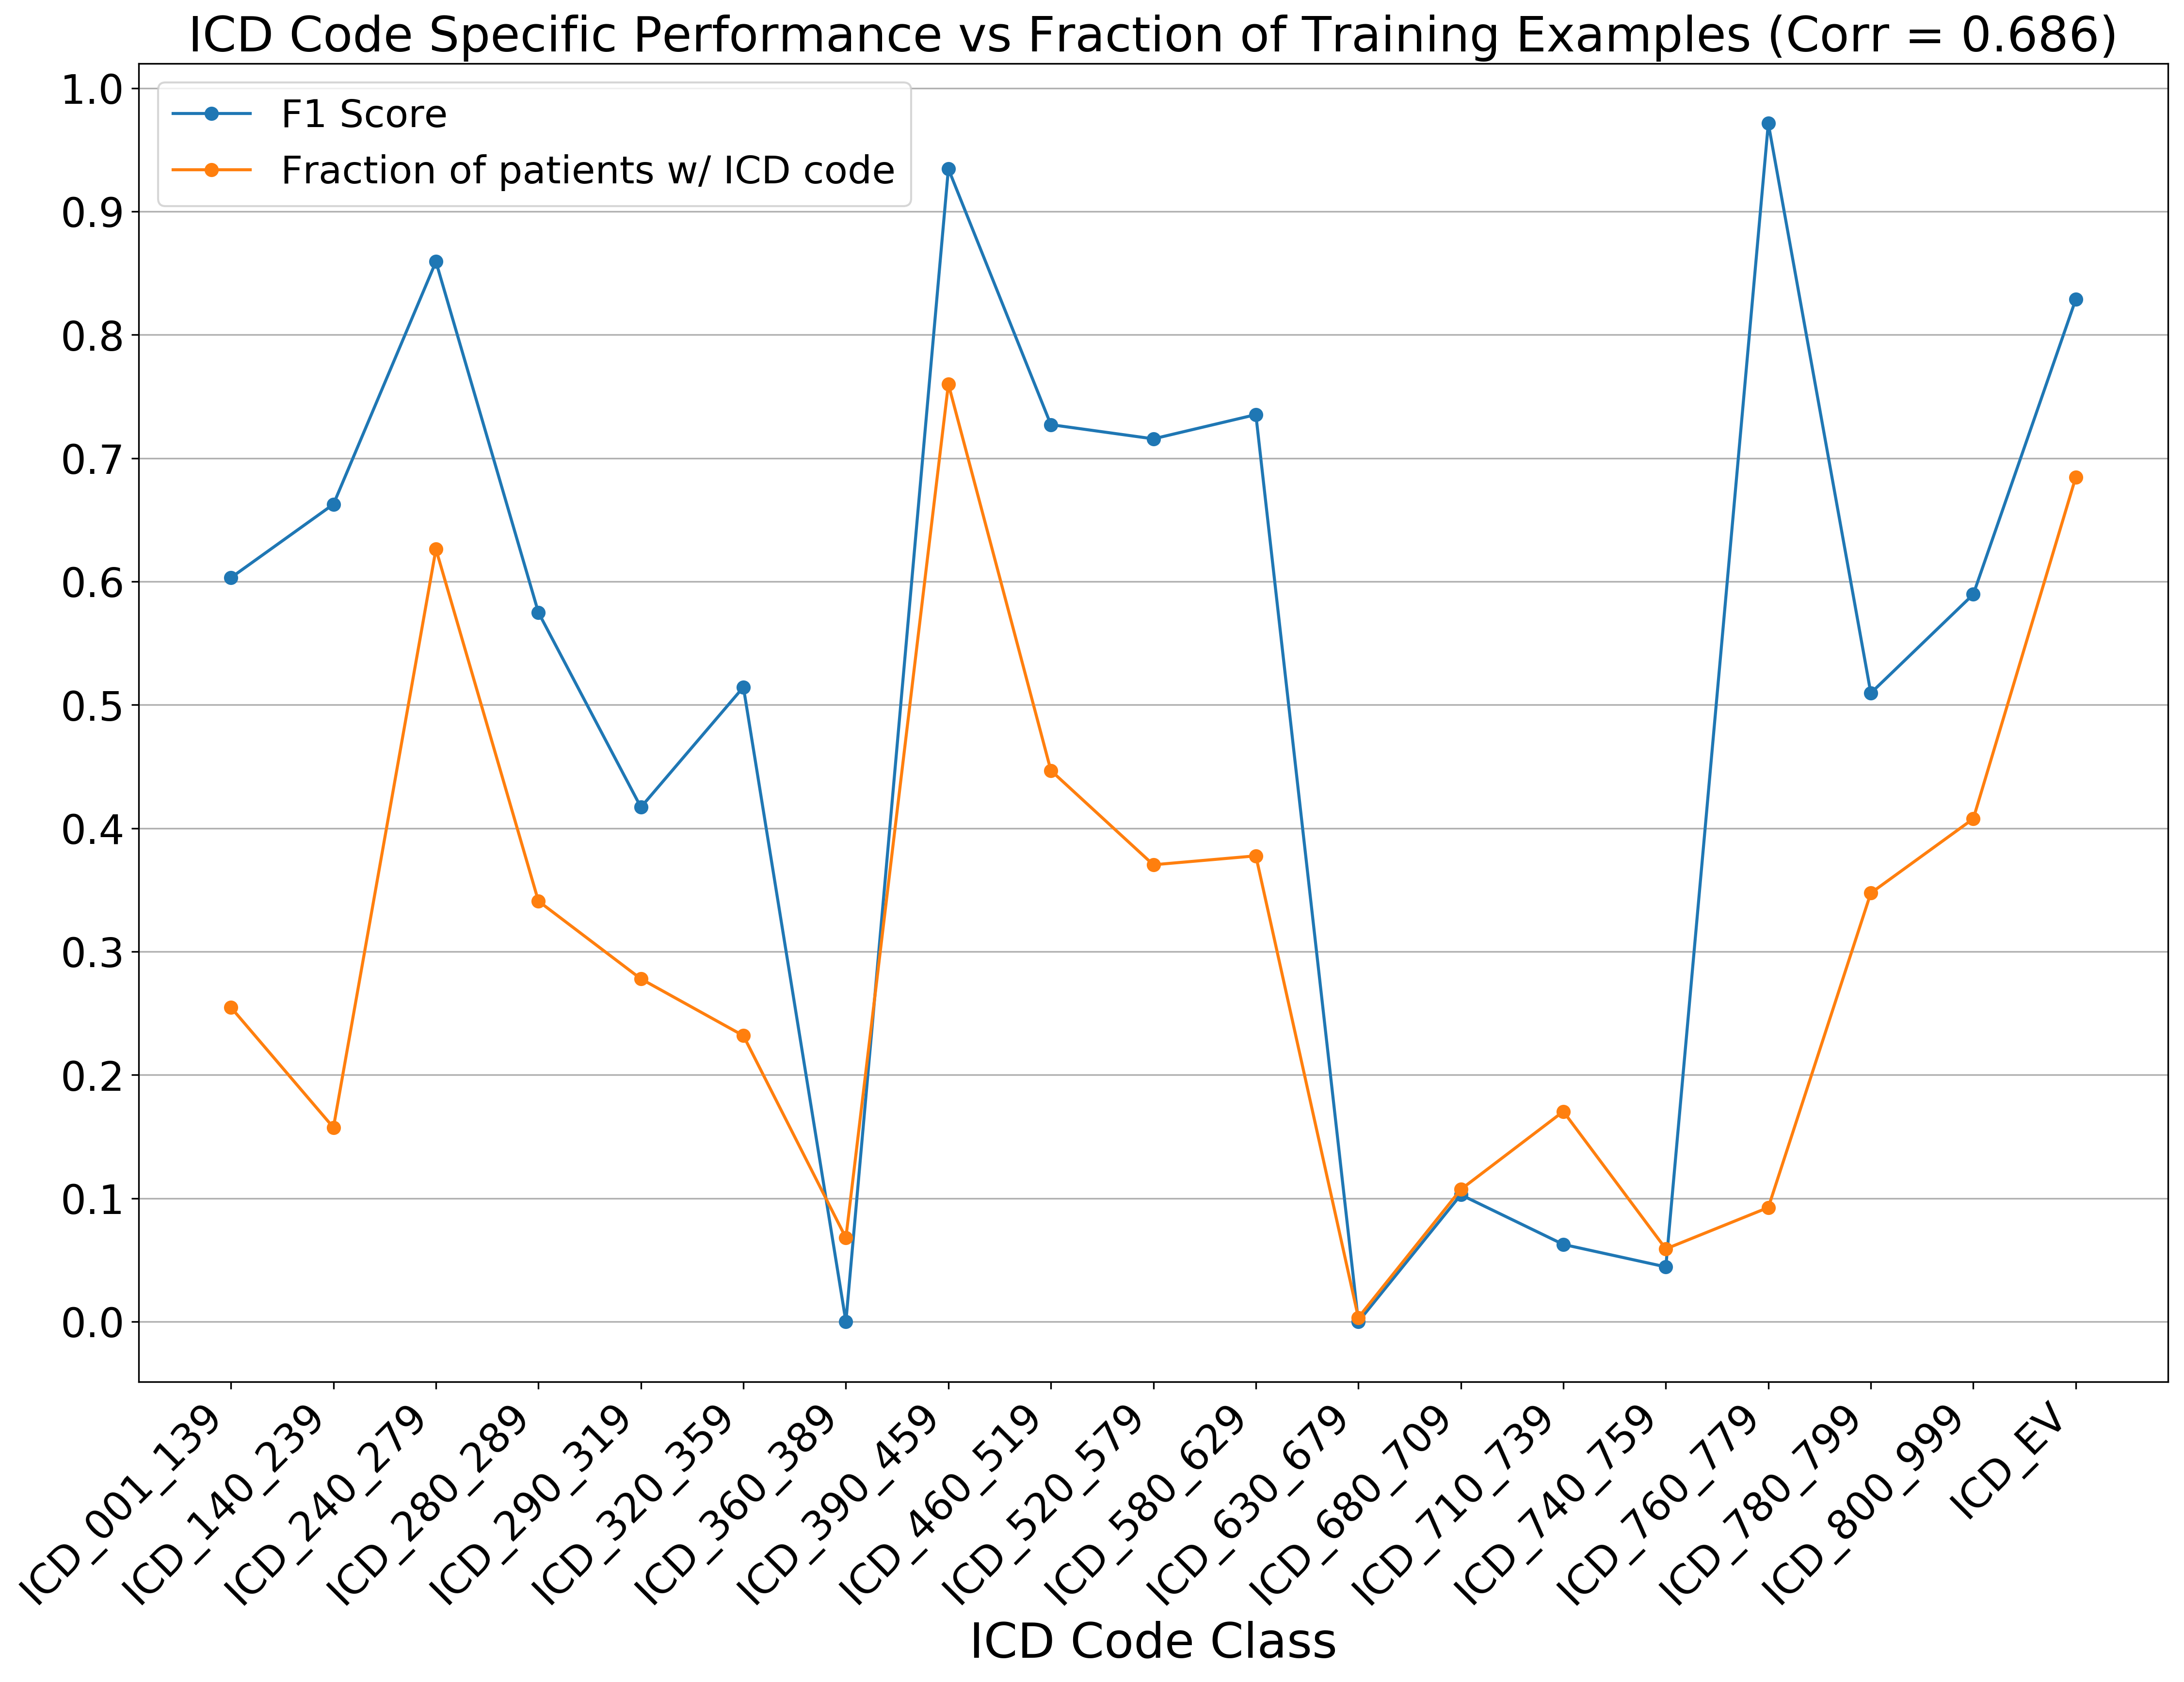

In [154]:
predsBest = preds[bestEpoch,:,:]
yTruth = yDev
classTrainingExamples = np.sum(yTrain, axis = 0)
# confusionMatrix = np.zeros(shape = (temp.shape[1], temp.shape[1]))
# print(confusionMatrix)-
# currTruth = np.zeros(temp.shape[1])
# currPred = np.zeros(temp.shape[1])
diseaseSpecificScores_F1 = np.zeros(classTrainingExamples.shape)
diseaseSpecificScores_Prec = np.zeros(classTrainingExamples.shape)
diseaseSpecificScores_Rec = np.zeros(classTrainingExamples.shape)
for colIdx in range(yTruth.shape[1]):
    currTruth = yTruth[:, colIdx]
    currPred = predsBest[:, colIdx]
    confMat = metrics.confusion_matrix(y_true = currTruth, y_pred = currPred)
#     print(confMat)
    prec = metrics.precision_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    rec = metrics.recall_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    f1 = metrics.f1_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    diseaseSpecificScores_F1[colIdx] = f1
    diseaseSpecificScores_Prec[colIdx] = prec
    diseaseSpecificScores_Rec[colIdx] = rec
#     print('total positives {} or {} of the total'.format(np.sum(currPred), np.mean(currPred)))
#     print('For Column {}'.format(colIdx))
# #     print('precision {}'.format(prec))
# #     print('recall {}'.format(rec))
#     print('f1 score {}'.format(f1))
#     print('Number of training examples {}'.format(classTrainingExamples[colIdx]))
#     print('Percent of training examples {}'.format(classTrainingExamples[colIdx]/yTrain.shape[0]))
#     print('***************************')




nClasses = yTrain.shape[1]
# fig = plt.figure(dpi = 300)
width = 18
height = 12
fig = plt.figure(dpi = 300, figsize=(width, height))
x = range(1, nClasses + 1)
diseaseSpecificScores_F1 = [diseaseSpecificScores_F1[sortedIdx] for sortedIdx in sortedAxisLabels]
plt.plot(x, diseaseSpecificScores_F1, linestyle='-', marker='o')
factionOfObsPerDisease = classTrainingExamples/yTrain.shape[0]
factionOfObsPerDisease = [factionOfObsPerDisease[sortedIdx] for sortedIdx in sortedAxisLabels]
my_xticks = xAxisLabels
my_xticks = [my_xticks[sortedIdx] for sortedIdx in sortedAxisLabels]
plt.plot(x, factionOfObsPerDisease, linestyle='-', marker='o')
# plt.axis([0, nClasses + 0, 0, 1.15])
plt.xticks(np.arange(1, nClasses + 1, 1.0), my_xticks, rotation=45, ha = 'right')
# plt.xticks(range(5), ["some", "words", "as", "x", "ticks"], rotation=45)
plt.yticks(np.arange(0, 1.1, 0.1))

# plt.legend(['F1 Score', 'Precision', 'Recall', 'Percent of observations w/ class'], loc='upper right', fontsize = 12)
plt.legend(['F1 Score', 'Fraction of patients w/ ICD code'], loc='upper left', fontsize = 19)

plt.title('ICD Code Specific Performance vs Fraction of Training Examples (Corr = 0.686)', fontsize = 24)
plt.xlabel('ICD Code Class', fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.grid(True)
plt.gca().yaxis.grid(True)

plt.show()
fig.savefig(os.path.join(resultPath, 'diseaseSpecific.png'))
# fig.savefig('src/plotting/resultPlotting/performance.png')

In [62]:
np.corrcoef(diseaseSpecificScores_F1, classTrainingExamples)

array([[ 1.        ,  0.71498595],
       [ 0.71498595,  1.        ]])

In [69]:
import scipy
scipy.stats.spearmanr(diseaseSpecificScores_F1, classTrainingExamples)

SpearmanrResult(correlation=0.68626597216453156, pvalue=0.0011764175548838426)

In [110]:
scipy.stats.spearmanr(diseaseSpecificScores_F1, factionOfObsPerDisease)

SpearmanrResult(correlation=0.68626597216453156, pvalue=0.0011764175548838426)

In [121]:
len(factionOfObsPerDisease)

19

In [133]:
len(np.arange(0, nClasses + 1, 1.0)) #, my_xticks

20